# Modeling Food Serving Sizes Through Nutrition Profiles

### Notebook 3 - Modeling

## Table of Contents

1. [Importing Packages](#Importing-Packages)
2. [Reading Data](#Reading-Data)
3. [Feature Engineering](#Feature-Engineering)
4. [Preprocessing](#Preprocessing)
5. [Modeling](#Modeling)
    1. [Baseline Model](#Baseline-Model)
    2. [Linear Regression](#Linear-Regression)
    3. [Ridge Regression](#Ridge-Regression)
    4. [LASSO Regression](#LASSO-Regression)
    5. [Neural Network](#Neural-Network)
6. [Model Evaluations](#Model-Evaluations)
    1. [R<sup>2</sup> Score](#R2-Score)
    2. [Mean Squared Error](#Mean-Squared-Error)
    3. [Visualizations](#Visualizations)
7. [Conclusions and Recommendations](#Conclusions-and-Recommendations)
    1. [Conclusions](#Conclusions)
    2. [Recommendations](#Recommendations)

## Importing Packages

In [225]:
# general tools/visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import set_random_seed

# imports for NLP
import regex as re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# imports for modeling
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, SGDRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

# making the magic happen for plots
%matplotlib inline

# setting options for better viewing
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 50)

# setting global random seeds for numpy and tensorflow
# np.random.seed(42)
# set_random_seed(42)

## Reading Data

In [311]:
foods = pd.read_csv("../datasets/clean_foods_df.csv")

In [312]:
foods.head()

,fdc_id,brand_owner,branded_food_category,description,ingredients,serving_size,household_serving_fulltext,energy,fat_total,fat_sat,fat_trans,chol,protein,carbs,fiber,sugars,sodium
0,356425,"G. T. Japan, Inc.",Ice Cream & Frozen Yogurt,MOCHI ICE CREAM BONBONS,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",40.0,1 PIECE,200.0,6.25,3.75,0.0,25.0,2.5,35.00,0.0,30.00,75.0
1,356426,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",CHIPOTLE BARBECUE SAUCE,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",37.0,2 Tbsp,162.0,0.00,0.00,0.0,0.0,0.0,43.24,0.0,37.84,703.0
2,356427,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",HOT & SPICY BARBECUE SAUCE,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",34.0,2 Tbsp,176.0,0.00,0.00,0.0,0.0,0.0,41.18,0.0,35.29,676.0
3,356428,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",35.0,2 Tbsp,143.0,0.00,0.00,0.0,0.0,0.0,34.29,0.0,28.57,971.0
4,356429,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",37.0,2 Tbsp,189.0,0.00,0.00,0.0,0.0,0.0,45.95,0.0,43.24,757.0


## Feature Engineering

Before the modeling process begins, we need to fully prepare the dataset. In the previous notebook we had seen the tailed distribution of the serving size target, so we will make a new column here to use as the target for modeling.

In [313]:
foods["log_serv"] = np.log(foods["serving_size"])

Since we want to use the category of the food product as a feature, we will have to turn them into dummy columns first.

In [314]:
foods = pd.get_dummies(data=foods,
                       columns=["branded_food_category"],
                       prefix="cat",
                       drop_first=True)

In [315]:
# checking for new cols
foods.head()

,fdc_id,brand_owner,description,ingredients,serving_size,household_serving_fulltext,energy,fat_total,fat_sat,fat_trans,chol,protein,carbs,fiber,sugars,sodium,log_serv,cat_All Noodles,"cat_Bacon, Sausages & Ribs",cat_Baking,cat_Baking Accessories,cat_Baking Additives & Extracts,cat_Baking Decorations & Dessert Toppings,cat_Baking/Cooking Mixes (Perishable),cat_Baking/Cooking Mixes (Shelf Stable),cat_Baking/Cooking Mixes/Supplies Variety Packs,cat_Baking/Cooking Supplies (Shelf Stable),cat_Beef - Prepared/Processed,cat_Biscuits/Cookies (Shelf Stable),cat_Bread & Muffin Mixes,cat_Breads & Buns,cat_Breakfast Drinks,cat_Breakfast Foods,"cat_Breakfast Sandwiches, Biscuits & Meals",cat_Butter & Spread,"cat_Cake, Cookie & Cupcake Mixes",cat_Cakes - Sweet (Frozen),cat_Cakes - Sweet (Shelf Stable),"cat_Cakes, Cupcakes, Snack Cakes",cat_Candy,cat_Canned & Bottled Beans,cat_Canned Condensed Soup,cat_Canned Fruit,cat_Canned Meat,cat_Canned Seafood,cat_Canned Soup,cat_Canned Tuna,cat_Canned Vegetables,cat_Cereal,cat_Cereal/Muesli Bars,...,"cat_Pancakes, Waffles, French Toast & Crepes",cat_Pasta Dinners,cat_Pasta by Shape & Type,cat_Pasta/Noodles - Not Ready to Eat (Frozen),cat_Pastry Shells & Fillings,"cat_Pepperoni, Salami & Cold Cuts","cat_Pickles, Olives, Peppers & Relishes",cat_Pies/Pastries - Sweet (Shelf Stable),cat_Pies/Pastries/Pizzas/Quiches - Savoury (Frozen),cat_Pizza,cat_Pizza Mixes & Other Dry Dinners,cat_Plant Based Milk,cat_Plant Based Water,cat_Popcorn (Shelf Stable),"cat_Popcorn, Peanuts, Seeds & Related Snacks",cat_Pork Sausages - Prepared/Processed,"cat_Poultry, Chicken & Turkey",cat_Powdered Drinks,cat_Pre-Packaged Fruit & Vegetables,cat_Prepared Pasta & Pizza Sauces,cat_Prepared Subs & Sandwiches,cat_Prepared Wraps and Burittos,cat_Processed Cheese & Cheese Novelties,cat_Puddings & Custards,cat_Rice,cat_Salad Dressing & Mayonnaise,"cat_Sausages, Hotdogs & Brats","cat_Seasoning Mixes, Salts, Marinades & Tenderizers","cat_Snack, Energy & Granola Bars",cat_Soda,cat_Soups - Prepared (Shelf Stable),cat_Specialty Formula Supplements,cat_Sport Drinks,cat_Stuffing,cat_Sushi,cat_Syrups & Molasses,cat_Tea Bags,cat_Tomatoes,cat_Vegetable & Cooking Oils,cat_Vegetable Based Products / Meals - Not Ready to Eat (Frozen),cat_Vegetable and Lentil Mixes,cat_Vegetables - Prepared/Processed (Frozen),cat_Vegetables - Prepared/Processed (Shelf Stable),cat_Vegetarian Frozen Meats,cat_Vitamins,cat_Water,cat_Weight Control,cat_Wholesome Snacks,cat_Yogurt,cat_Yogurt/Yogurt Substitutes (Perishable)
0,356425,"G. T. Japan, Inc.",MOCHI ICE CREAM BONBONS,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",40.0,1 PIECE,200.0,6.25,3.75,0.0,25.0,2.5,35.00,0.0,30.00,75.0,3.688879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,356426,FRESH & EASY,CHIPOTLE BARBECUE SAUCE,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",37.0,2 Tbsp,162.0,0.00,0.00,0.0,0.0,0.0,43.24,0.0,37.84,703.0,3.610918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,356427,FRESH & EASY,HOT & SPICY BARBECUE SAUCE,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",34.0,2 Tbsp,176.0,0.00,0.00,0.0,0.0,0.0,41.18,0.0,35.29,676.0,3.526361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,356428,FRESH & EASY,BARBECUE SAUCE,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",35.0,2 Tbsp,143.0,0.00,0.00,0.0,0.0,0.0,34.29,0.0,28.57,971.0,3.555348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,356429,FRESH & EASY,BARBECUE SAUCE,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",37.0,2 Tbsp,189.0,0.00,0.00,0

## Preprocessing

Our preprocessing steps here are to split our dataset into the X features and y target, and then scale the features so they can be flexibly used across different model types.

In [231]:
# setting X and y vars
X = foods.drop(columns=["fdc_id", 
                        "brand_owner", 
                        "description", 
                        "ingredients", 
                        "household_serving_fulltext",
                        "serving_size",
                       "log_serv"])
y = foods["log_serv"]

In [232]:
# splitting data to train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# instantiating scaler
ss = StandardScaler()

# scaling X data
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

Now that the data has been fully prepared, we can beign the modeling process.

## Modeling

### Baseline Model

There is a way of predicting serving size without using any machine learning, by simply using the mean of the target. 

In [256]:
# building a base model to compare results against
# using code from Boom's Local Session

# Instantiate: creates a dummy regression that always predicts the mean of the target
base_mean = DummyRegressor(strategy='mean')

# Fit the "model"
base_mean = base_mean.fit(X_train_sc, y_train)

# Get predictions for our testing set (not kaggle testing set)
y_hat_base_train = base_mean.predict(X_train_sc)
y_hat_base_test = base_mean.predict(X_test_sc)

# Get R2
print("Our Train MSE Score for our Base Model is:", metrics.mean_squared_error(np.exp(y_train),np.exp(y_hat_base_train)))
print("Our Test MSE Score for our Base Model is:",  metrics.mean_squared_error(np.exp(y_test),np.exp(y_hat_base_test)))

Our Train MSE Score for our Base Model is: 3685.336822662155
Our Test MSE Score for our Base Model is: 3833.116046199187


### GridSearch Function

The help find the best possible model parameters, we should build a function to perform gridsearches for us. We can then implement this function on any model type and set of parameters to optimize each one.

In [210]:
# bringing in func from Reddit NLP project
def grid_searcher(pipe, params):
    gs = GridSearchCV(estimator=pipe, param_grid=params, cv=3, verbose=1, n_jobs=3)
    gs.fit(X_train_sc, y_train)
    print(f'CrossVal Score: {gs.best_score_}')
    print(f'Training Score: {gs.score(X_train_sc, y_train)}')
    print(f'Testing Score: {gs.score(X_test_sc, y_test)}')
    print(gs.best_params_)
    return gs

### Linear Regression

As linear regression is a very simple model, there is really no hyperparameter searching that needs to be performed. 

In [245]:
linreg = LinearRegression()
linreg_model = linreg.fit(X_train, y_train)

In [246]:
print(f"The train R2 score is: {linreg_model.score(X_train, y_train)}.")
print(f"The test R2 score is: {linreg_model.score(X_test, y_test)}.")

The train R2 score is: 0.7353463856717573.
The test R2 score is: 0.7406407151042635.


This basic linear regression model is not scoring very high, although it is also showing a fairly low variance. Since we did see some multicolinearity in a few of the features during the EDA, it may be worth looking at a LASSO or ridge regression for some improvements.

### LASSO Regression

As the `LassoCV` model already iterates through a list of 100 alphas, we do not need torun the gridsearching function on it. 

In [151]:
lasso = LassoCV()
lasso_model = lasso.fit(X_train_sc, y_train)

/Users/jondov/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [152]:
print(f"The train R2 score is: {lasso_model.score(X_train_sc, y_train)}.")
print(f"The test R2 score is: {lasso_model.score(X_test_sc, y_test)}.")

The train R2 score is: 0.7351460362337019.
The test R2 score is: 0.7403776480182412.


### Ridge Regression

In [57]:
ridge_pipe = Pipeline([("ridge", Ridge())])

ridge_params = {
    "ridge__alpha": [11, 12, 13]
}

In [58]:
ridge_model = grid_searcher(ridge_pipe, ridge_params)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   13.8s finished


CrossVal Score: 0.7338202830606281
Training Score: 0.7353441884095184
Testing Score: 0.7406257916854004
{'ridge__alpha': 12}


Neither of these regularization methods had any large impact on the R<sup>2</sup> scores. These model are typically most helpful to regularize overfit linear regressions, and as our initial model was not very overfit, they may not just not be enough of an improvement. We may need to utilize a more advanced regression method.

### Neural Network

As using a Neural Network was showing promise as the best model type to use, we should have a way of effectively optimizing it. While a Keras Sequential model cannot be passed through Scikit-learn's `GridSearchCV`, we can make our own custom function to essentially perform the same type of task. To that end, the following functions were created, which were adapted from code written by Mahdi Shadkam-Farrokhi.

The first function to be made is for establishing the permutations of parameters. This fucntion will take in a dictionary of all the layer parameters, and unpacks each combination into a distinct set of single parameters that a model can be built on.

In [41]:
def permutate_params(grid_params):
    # returns a list of all combinations of unique parameters from the given dictionary
    out = [{}]
    for param_name, param_list in grid_params.items():
        if len(param_list) == 1:
            for item in out:
                item[param_name] = param_list[0]
        else:
            temp_out = []
            for param_val in param_list:
                for item in out:
                    cloned_item = item.copy()
                    cloned_item[param_name] = param_val
                    temp_out.append(cloned_item)
            out = temp_out
    return out

The next piece is to take a dictionary of parameters and build a functioning model out of it. We will make a model building fucntion to perfrom this action. It will take our train/test split data, and a dictionary of the parameters that has the specified keys. The function will reach into each of the keys for the appropriate attribute, and then apply that to the coresponding layer. To increase flexibility, there will be default settings for each of the parameters, so that the dictioanry does not have to contain entries for everything.

In [74]:
def build_model(params_dict, X_train, X_test, y_train, y_test):
    # defining params
    first_layer_nodes = params_dict.get("first_layer_nodes") or 16            # default low nodes
    first_dropout_rate = params_dict.get("first_dropout_rate") or 0.0         # default no dropout
    
    second_layer_nodes = params_dict.get("second_layer_nodes") or 16          # default low nodes
    second_dropout_rate = params_dict.get("second_dropout_rate") or 0.0       # default no dropout
    
    third_layer_nodes = params_dict.get("third_layer_nodes") or 16            # default low nodes
    third_dropout_rate = params_dict.get("third_dropout_rate") or 0.0         # default no dropout  
    
    reg = params_dict.get("reg") or 0                                         # default no reg
    
    epochs = params_dict.get("epochs") or 10                                  # default low epochs
    batch_size = params_dict.get("batch_size") or 1024                        # default large batch
    early_stop = params_dict.get("early_stop") or EarlyStopping(monitor="val_loss",
                                                                min_delta=0.000000001,  # small delta
                                                                patience=100)           # large patience
    
    # instantiating model
    model = Sequential()

    # adding layers according to inputs
    # first layer(s)
    model.add(Dense(first_layer_nodes,
                   activation="relu",
                   input_shape=(X_train.shape[1],),
                   kernel_regularizer=regularizers.l2(reg)))
    model.add(Dropout(first_dropout_rate))
    
    # second layer(s)
    model.add(Dense(second_layer_nodes,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(reg)))
    model.add(Dropout(second_dropout_rate))
    
    # third layer(s)
    model.add(Dense(third_layer_nodes,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(reg)))
    model.add(Dropout(third_dropout_rate))
    
    # output layer
    model.add(Dense(1))
    
    # compiling model
    model.compile(loss="mean_squared_error",
             optimizer="adam")
    
    # fitting model according to inputs
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                       callbacks=[early_stop])
    return model, history

The final piece is to combine the two above functions into one functioan that will take and X and y, along with the parameter dictionary, and do the rest of the work for us. This function performs a train/test split, scales the data, and the runs the data through each of the models fit within the parameter dictionary. Each iteration will check the determined metric, and updates it if it has been improved. At the end of the function, the model that gave the best score for the metric is returned.

In [43]:
def nn_grid_search(
    X,
    y,
    grid_params,
    random_state=42
):
    ### this will make a series of FFNN models 
    ### and return the one with the best score as set below
    ### currently set to test r2 score
    
    # list of all parameter combinations
    all_params = permutate_params(grid_params)
    
    # creating vars with to update each iter
    best_model = None
    best_score = 0.0 # no accuracy to start
    best_params = None
    best_history = None
    
    # train/test split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # scaling data
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    # looping through the unpacked parameter list
    for i, params in enumerate(all_params):
        
        # keeping track of which model we're running
        print(f"Building model {i + 1} of {len(all_params)}")
        
        # bulding the model
        model, history = build_model(
            params_dict = params,
            X_train = X_train_sc, 
            X_test = X_test_sc, 
            y_train = y_train, 
            y_test = y_test
        )
        
        # making preds and scoring
        test_preds = model.predict(X_test_sc)
        score = metrics.r2_score(y_test, test_preds)
        
        # checking if the score beats the current best
        # updates vars if true
        if score > best_score:
            print("***Good R2 found: {:.2%}***".format(score))
            best_score = score
            best_model = model
            best_params = params
            best_history = history
    
    # loop is done, return the best model
    return {
        "best_model"   : best_model,
        "best_score"   : best_score,
        "best_params"  : best_params,
        "best_history" : best_history,
        "test_preds"   : test_preds
    }

Now that we have our functions built, we can run the search. We will start with finding the best number of nodes out of three hidden layers.

In [49]:
# setting params
node_params = {
    "first_layer_nodes": [256, 128, 64],
    "second_layer_nodes": [128, 64, 32],
    "third_layer_nodes": [64, 32, 16],
}

In [50]:
# best_model = nn_grid_search(X, y, node_params)

Building model 1 of 27
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 141859 samples, validate on 47287 samples
Epoch 1/10
141859/141859 [==============================] - 3s 23us/step - loss: 1.8480 - val_loss: 0.2177
Epoch 2/10
141859/141859 [==============================] - 3s 20us/step - loss: 0.2511 - val_loss: 0.1866
Epoch 3/10
141859/141859 [==============================] - 3s 22us/step - loss: 0.1780 - val_loss: 0.1720
Epoch 4/10
141859/141859 [==============================] - 3s 21us/step - loss: 0.1655 - val_loss: 0.1588
Epoch 5/10
141859/141859 [==============================] - 3s 22us/step - loss: 0.1560 - val_loss: 0.1517
Epoch 6/10
141859/141859 [==============================] - 3s 22us/step - loss: 0.1503 - val_loss: 0.1508
Epoch 7/10
141859/141859 [==============================] - 3s 23us/step - loss: 0.1458 - val_loss: 0.1423
Epoch 8/10
141859/141859 [==============================]

141859/141859 [==============================] - 2s 13us/step - loss: 0.1522 - val_loss: 0.1479
Epoch 8/10
141859/141859 [==============================] - 2s 13us/step - loss: 0.1476 - val_loss: 0.1437
Epoch 9/10
141859/141859 [==============================] - 2s 13us/step - loss: 0.1417 - val_loss: 0.1404
Epoch 10/10
141859/141859 [==============================] - 2s 13us/step - loss: 0.1365 - val_loss: 0.1378
Building model 15 of 27
Train on 141859 samples, validate on 47287 samples
Epoch 1/10
141859/141859 [==============================] - 3s 19us/step - loss: 1.8320 - val_loss: 0.2708
Epoch 2/10
141859/141859 [==============================] - 2s 11us/step - loss: 0.2465 - val_loss: 0.1952
Epoch 3/10
141859/141859 [==============================] - 2s 11us/step - loss: 0.1865 - val_loss: 0.1779
Epoch 4/10
141859/141859 [==============================] - 2s 11us/step - loss: 0.1729 - val_loss: 0.1673
Epoch 5/10
141859/141859 [==============================] - 2s 11us/step - loss

After the grid search has completed, we have a list of dictionaries that holds the model that gave use the highest R<sup>2</sup> score, along with the parameters of that model, the score, and the history.

In [80]:
best_model

NameError: name 'best_model' is not defined

We can now take the model that had the best promise, and use those parameters in a new model to find the best amount of epochs for it. After some trials, 75 epochs seemed to be the best number to use, though we were left with some slight overfitting, so an additional search will be performed with some regularization applied.

In [72]:
pdict = {
    "first_layer_nodes": [256],
    "first_dropout_rate": [0.25, 0.5],
    "second_layer_nodes": [128],
    "second_dropout_rate": [0.25, 0.5],
    "third_layer_nodes": [32],
    "third_dropout_rate": [0.25, 0.5],
    "epochs": [75]
}

In [75]:
final_nn_model = nn_grid_search(X, y, grid_params=pdict)

Building model 1 of 8
Train on 141859 samples, validate on 47287 samples
Epoch 1/75
141859/141859 [==============================] - 6s 39us/step - loss: 2.5056 - val_loss: 0.3672
Epoch 2/75
141859/141859 [==============================] - 4s 27us/step - loss: 0.9568 - val_loss: 0.2869
Epoch 3/75
141859/141859 [==============================] - 4s 27us/step - loss: 0.8180 - val_loss: 0.2617
Epoch 4/75
141859/141859 [==============================] - 4s 27us/step - loss: 0.7392 - val_loss: 0.2592
Epoch 5/75
141859/141859 [==============================] - 4s 27us/step - loss: 0.6748 - val_loss: 0.2313
Epoch 6/75
141859/141859 [==============================] - 4s 27us/step - loss: 0.6359 - val_loss: 0.2231
Epoch 7/75
141859/141859 [==============================] - 4s 28us/step - loss: 0.6047 - val_loss: 0.2506
Epoch 8/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.5729 - val_loss: 0.2350
Epoch 9/75
141859/141859 [==============================] - 4s 28us/ste

Train on 141859 samples, validate on 47287 samples
Epoch 1/75
141859/141859 [==============================] - 5s 38us/step - loss: 3.0929 - val_loss: 0.7281
Epoch 2/75
141859/141859 [==============================] - 4s 27us/step - loss: 1.1999 - val_loss: 0.7055
Epoch 3/75
141859/141859 [==============================] - 4s 25us/step - loss: 0.9508 - val_loss: 0.7631
Epoch 4/75
141859/141859 [==============================] - 4s 25us/step - loss: 0.8411 - val_loss: 0.7650
Epoch 5/75
141859/141859 [==============================] - 4s 25us/step - loss: 0.7586 - val_loss: 0.7721
Epoch 6/75
141859/141859 [==============================] - 4s 27us/step - loss: 0.6958 - val_loss: 0.7211
Epoch 7/75
141859/141859 [==============================] - 4s 25us/step - loss: 0.6489 - val_loss: 0.7101
Epoch 8/75
141859/141859 [==============================] - 4s 25us/step - loss: 0.6075 - val_loss: 0.6782
Epoch 9/75
141859/141859 [==============================] - 4s 25us/step - loss: 0.5742 - val

141859/141859 [==============================] - 6s 41us/step - loss: 2.8603 - val_loss: 0.6142
Epoch 2/75
141859/141859 [==============================] - 4s 28us/step - loss: 1.1605 - val_loss: 0.5834
Epoch 3/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.9461 - val_loss: 0.5282
Epoch 4/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.8301 - val_loss: 0.4050
Epoch 5/75
141859/141859 [==============================] - 4s 28us/step - loss: 0.7499 - val_loss: 0.4065
Epoch 6/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.6863 - val_loss: 0.3309
Epoch 7/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.6370 - val_loss: 0.2939
Epoch 8/75
141859/141859 [==============================] - 4s 28us/step - loss: 0.5808 - val_loss: 0.2452
Epoch 9/75
141859/141859 [==============================] - 4s 28us/step - loss: 0.5311 - val_loss: 0.2333
Epoch 10/75
141859/141859 [=====================

141859/141859 [==============================] - 6s 46us/step - loss: 3.7948 - val_loss: 0.8782
Epoch 2/75
141859/141859 [==============================] - 4s 28us/step - loss: 1.5692 - val_loss: 0.9334
Epoch 3/75
141859/141859 [==============================] - 4s 31us/step - loss: 1.2432 - val_loss: 0.8287
Epoch 4/75
141859/141859 [==============================] - 4s 26us/step - loss: 1.1003 - val_loss: 0.8062
Epoch 5/75
141859/141859 [==============================] - 4s 25us/step - loss: 0.9896 - val_loss: 0.6206
Epoch 6/75
141859/141859 [==============================] - 4s 28us/step - loss: 0.9175 - val_loss: 0.5072
Epoch 7/75
141859/141859 [==============================] - 4s 30us/step - loss: 0.8169 - val_loss: 0.4770
Epoch 8/75
141859/141859 [==============================] - 4s 26us/step - loss: 0.7470 - val_loss: 0.4420
Epoch 9/75
141859/141859 [==============================] - 4s 31us/step - loss: 0.6939 - val_loss: 0.4085
Epoch 10/75
141859/141859 [=====================

141859/141859 [==============================] - 6s 44us/step - loss: 3.3205 - val_loss: 0.5380
Epoch 2/75
141859/141859 [==============================] - 4s 31us/step - loss: 1.6474 - val_loss: 0.5033
Epoch 3/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.4114 - val_loss: 0.4204
Epoch 4/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.2826 - val_loss: 0.3725
Epoch 5/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.2030 - val_loss: 0.3366
Epoch 6/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.1310 - val_loss: 0.4062
Epoch 7/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.0557 - val_loss: 0.3553
Epoch 8/75
141859/141859 [==============================] - 5s 32us/step - loss: 0.9931 - val_loss: 0.3347
Epoch 9/75
141859/141859 [==============================] - 5s 36us/step - loss: 0.9312 - val_loss: 0.3285
Epoch 10/75
141859/141859 [=====================

141859/141859 [==============================] - 7s 50us/step - loss: 3.6219 - val_loss: 0.7676
Epoch 2/75
141859/141859 [==============================] - 4s 30us/step - loss: 1.8249 - val_loss: 0.8386
Epoch 3/75
141859/141859 [==============================] - 4s 30us/step - loss: 1.5763 - val_loss: 0.7691
Epoch 4/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.3865 - val_loss: 0.7743
Epoch 5/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.2605 - val_loss: 0.8039
Epoch 6/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.1761 - val_loss: 0.7242
Epoch 7/75
141859/141859 [==============================] - 5s 37us/step - loss: 1.0980 - val_loss: 0.7234
Epoch 8/75
141859/141859 [==============================] - 5s 37us/step - loss: 1.0351 - val_loss: 0.7100
Epoch 9/75
141859/141859 [==============================] - 5s 37us/step - loss: 0.9721 - val_loss: 0.6204
Epoch 10/75
141859/141859 [=====================

141859/141859 [==============================] - 6s 45us/step - loss: 3.5808 - val_loss: 0.8408
Epoch 2/75
141859/141859 [==============================] - 4s 30us/step - loss: 1.6855 - val_loss: 0.6833
Epoch 3/75
141859/141859 [==============================] - 4s 30us/step - loss: 1.4355 - val_loss: 0.5736
Epoch 4/75
141859/141859 [==============================] - 4s 30us/step - loss: 1.2857 - val_loss: 0.4416
Epoch 5/75
141859/141859 [==============================] - 5s 38us/step - loss: 1.1549 - val_loss: 0.4331
Epoch 6/75
141859/141859 [==============================] - 5s 32us/step - loss: 1.0708 - val_loss: 0.4260
Epoch 7/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.9772 - val_loss: 0.2945
Epoch 8/75
141859/141859 [==============================] - 4s 30us/step - loss: 0.8992 - val_loss: 0.2980
Epoch 9/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.8547 - val_loss: 0.2973
Epoch 10/75
141859/141859 [=====================

141859/141859 [==============================] - 6s 44us/step - loss: 3.6126 - val_loss: 1.7920
Epoch 2/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.8524 - val_loss: 1.3186
Epoch 3/75
141859/141859 [==============================] - 4s 31us/step - loss: 1.5096 - val_loss: 1.0780
Epoch 4/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.2923 - val_loss: 0.8128
Epoch 5/75
141859/141859 [==============================] - 4s 29us/step - loss: 1.1580 - val_loss: 0.6719
Epoch 6/75
141859/141859 [==============================] - 4s 30us/step - loss: 1.0269 - val_loss: 0.6225
Epoch 7/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.9255 - val_loss: 0.5364
Epoch 8/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.8454 - val_loss: 0.4418
Epoch 9/75
141859/141859 [==============================] - 4s 29us/step - loss: 0.7776 - val_loss: 0.4037
Epoch 10/75
141859/141859 [=====================

Now that the grid search has 

In [76]:
final_nn_model

{'best_model': <keras.engine.sequential.Sequential at 0x1a557d7d10>,
 'best_score': 0.900713765015688,
 'best_params': {'first_layer_nodes': 256,
  'first_dropout_rate': 0.25,
  'second_layer_nodes': 128,
  'second_dropout_rate': 0.25,
  'third_layer_nodes': 32,
  'third_dropout_rate': 0.25,
  'epochs': 75},
 'best_history': <keras.callbacks.History at 0x1a57ce6550>,
 'test_preds': array([[5.648533 ],
        [4.497038 ],
        [3.839902 ],
        ...,
        [5.1945095],
        [4.4716697],
        [3.4207933]], dtype=float32)}

In [87]:
# making predictions
nn_train_preds = final_nn_model["best_model"].predict(X_train_sc)
nn_test_preds = final_nn_model["test_preds"]

In [88]:
metrics.r2_score(y_train, nn_train_preds)

0.907672063389299

In [89]:
metrics.r2_score(y_test, nn_test_preds)

0.8817637469051529

## Model Evaluations

To help automate the eavluations process, we are going to compile the train and test predictions for each of our models, and from there we will be able to easily evaluate the desired metrics from one spot.

In [307]:
# making train pred df
train_pred_df = pd.DataFrame(columns=["base",
                                     "linear",
                                     "lasso",
                                     "ridge",
                                     "neural_net"])

# making test pred df
test_pred_df = pd.DataFrame(columns=["base",
                                     "linear",
                                     "lasso",
                                     "ridge",
                                     "neural_net"])

In [308]:
# making a dict of our first 3 models
models = {"base": base_mean,
          "linear": linreg_model,
          "lasso": lasso_model,
          "ridge": ridge_model,}

# looping through models to input preds into df
for model in models.keys():
    train_pred_df[model] = np.exp(linreg_model.predict(X_train))
    test_pred_df[model] = np.exp(linreg_model.predict(X_test))

In [310]:
test_pred_df

,base,linear,lasso,ridge,neural_net
0,133.968872,133.968872,133.968872,133.968872,NaN
1,93.642083,93.642083,93.642083,93.642083,NaN
2,46.437591,46.437591,46.437591,46.437591,NaN
3,25.529767,25.529767,25.529767,25.529767,NaN
4,25.680915,25.680915,25.680915,25.680915,NaN
5,89.005597,89.005597,89.005597,89.005597,NaN
6,16.064228,16.064228,16.064228,16.064228,NaN
7,26.888248,26.888248,26.888248,26.888248,NaN
8,25.113277,25.113277,25.113277,25.113277,NaN
9,35.464983,35.464983,35.464983,35.464983,NaN


In [300]:
# making a df to store everything
model_df = pd.DataFrame(index=[model for model in models])

# making a dict of our first 3 models
models = {"base": base_mean,
          "linreg": linreg_model,
          "lasso": lasso_model,
          "ridge": ridge_model}

# making dict for preds
pred_dict = {}

for model in models.keys():
    pred_dict[f"{model}_train_pred"] = np.exp(linreg_model.predict(X_train))
    pred_dict[f"{model}_test_pred"] = np.exp(linreg_model.predict(X_test))

# putting in the training scores
model_df["train_r2"] = [round(metrics.mean_squared_error(X_train, y_train), 3) for model in models.values()]

# putting in the testing scores
model_df["test_r2"] = [round(model.score(X_test, y_test), 3) for model in models.values()]

# getting the difference, or variance, between each score
# model_df["var"] = model_df["train_"] - model_df["test_acc"]

# checking the final dataframe
model_df

,train_r2,test_r2
base,0.000,-0.000
linreg,0.735,0.741
lasso,-450216.910,-490520.151
ridge,-450693.411,-490641.546


### R<sup>2</sup> Score

We can evaluate both the normal R<sup>2</sup>, and adjusted R<sup>2</sup> scores for each of our models.

In [257]:
# bringing in custom adjusted r2 function from 3.01 Linear Reg Lab
def r2_adj(model, X, y):
    # seting some base variables
    n = len(y)
    k = len(X.columns)
    r_sq = model.score(X, y)
    
    # using the vars as inputs for the adjusted r2 equation
    r_sq_adj = 1 - (((1 - r_sq) * (n - 1)) / (n - k - 1))
    return r_sq_adj

In [316]:
# R2 scores are above in the modeling phase, just need to compile them and compare against adjusted r2 down here.

### Mean Squared Error

In [254]:
# finding mse for lasso model

# making predictions
linreg_train_preds = np.exp(linreg_model.predict(X_train))
linreg_test_preds = np.exp(linreg_model.predict(X_test))

# calculating mse
linreg_train_mse = metrics.mean_squared_error(np.exp(y_train), linreg_train_preds)
linreg_test_mse = metrics.mean_squared_error(np.exp(y_test), linreg_test_preds)

print(f"OLS train MSE: {linreg_train_mse}.")
print(f"OLS test MSE: {linreg_test_mse}.")

OLS train MSE: 1006.5988194771304.
OLS test MSE: 1066.4870318968215.


In [251]:
# finding mse for lasso model

# making predictions
lasso_train_preds = np.exp(lasso_model.predict(X_train_sc))
lasso_test_preds = np.exp(lasso_model.predict(X_test_sc))

# calculating mse
lasso_train_mse = metrics.mean_squared_error(np.exp(y_train), lasso_train_preds)
lasso_test_mse = metrics.mean_squared_error(np.exp(y_test), lasso_test_preds)

print(f"LASSO train MSE: {lasso_train_mse}.")
print(f"LASSO test MSE: {lasso_test_mse}.")

LASSO train MSE: 1006.7210399896342.
LASSO test MSE: 1067.9519777748644.


In [255]:
# finding mse for lasso model

# making predictions
ridge_train_preds = np.exp(ridge_model.predict(X_train_sc))
ridge_test_preds = np.exp(ridge_model.predict(X_test_sc))

# calculating mse
ridge_train_mse = metrics.mean_squared_error(np.exp(y_train), ridge_train_preds)
ridge_test_mse = metrics.mean_squared_error(np.exp(y_test), ridge_test_preds)

print(f"Ridge train MSE: {ridge_train_mse}.")
print(f"Ridge test MSE: {ridge_test_mse}.")

Ridge train MSE: 1006.6401361031418.
Ridge test MSE: 1066.5697180523443.


In [297]:
# finding mse for nn model

# making predictions
nn_train_preds = np.exp(final_model["best_model"].predict(X_train_sc))
nn_test_preds = np.exp(final_model["test_preds"])

# calculating mse
nn_train_mse = metrics.mean_squared_error(np.exp(y_train), nn_train_preds)
nn_test_mse = metrics.mean_squared_error(np.exp(y_test), nn_test_preds)

print(f"Neural network train MSE: {nn_train_mse}.")
print(f"Neural network test MSE: {nn_test_mse}.")

Neural network train MSE: 571.2166353561056.
Neural network test MSE: 730.6331446433081.


We can see from these numbers that the neural network had by far the lowest MSE scores, though it was somewhat more overfit than the others. However, due to how much better of a performance it was able to give us, we are going to select that as our final model.

### Visualizations

In [ ]:
# insert bar charts of mse and r2 here!

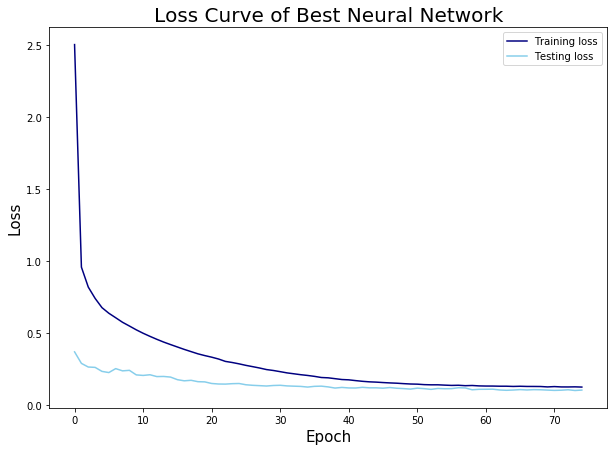

In [261]:
train_loss = final_model["best_history"].history["loss"]
test_loss = final_model["best_history"].history["val_loss"]


plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.title("Loss Curve of Best Neural Network", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("Loss", size=15)
plt.legend();

This line graph shows us how the loss of our final model changed as it ran through 75 epochs. There does not appear to be a lot of variation in the curves, and we have avoided divergence of the losses between the train and test set.

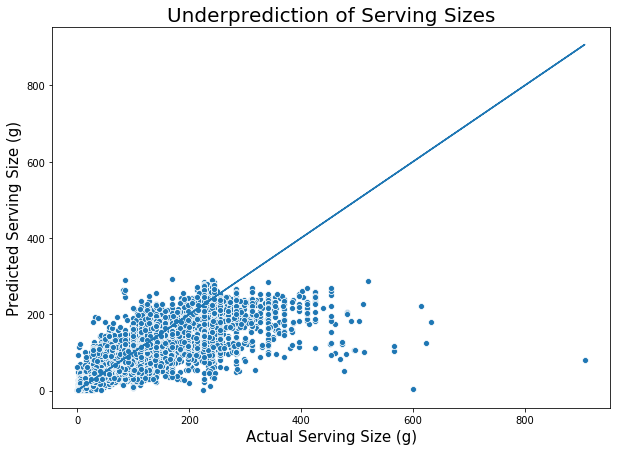

In [100]:
# trasnforming y back to actual sizes
y_test_gram = np.exp(y_test)
pred_test_gram = np.exp(nn_test_preds.reshape(-1,))

plt.figure(figsize=(10, 7))

# showing a scatter plot of the predicted vs actual serving sizes
sns.scatterplot(y_test_gram, pred_test_gram)

# setting the visuals
plt.title("Underprediction of Serving Sizes", size=20)
plt.xlabel("Actual Serving Size (g)", size=15)
# plt.xticks(list(range(0, 600_001, 75_000)))
plt.ylabel("Predicted Serving Size (g)", size=15)
# plt.yticks(list(range(0, 600_001, 75_000)))
plt.plot(y_test_gram, y_test_gram)

We can see from this comparison of predicted and actual serving sizes that our model has a clear tendency to underpredict servings as the real serving size increases. There could be several reasons behind why this is happening, though one clear and logical answer may be that some of those foods with larger serving sizes have larger portions of the food that are inedible. This could mean a food that has shells or pits, or something else that is counted in the total weight, but is not eaten. Unfortunately, these aspects were not accounted for in this model.

## Conclusions and Recommendations

### Conclusions

Utilizing a neural network gave use the best results overall. It was able to increase the R<sup>2</sup> score above 90%, and still limit variance to less than 2%. It was also able to minimize MSE fra better than the other models that were made. However, this model was still not perfect, and was subject to significant underpredcition as the true serving size increased. 

As discussed above, this may be influence by factors unseen by the model, such as the percentage of the food item that is not typically eaten. In addition, this model only takes certain attributes into account, and there are many other factors that can have an impact on serving size, such as package size, sale price, or targeted demographic. Many of these factors can be proprietary information to the manufacturing company, and are unavailable to the public, making a deeper analysis difficult. This could, however, be adapted within a specific company to account for some of these features, or to be trained on a more specific set of foods products.

In the end, this model should still be fairly useful to a project team that is working to develop a new food product. If the standard nutrition facts and category can be enterered, the resulting serving size should be fairly close to similar products on the market in that category, and can be useful in the development process. This way, researchers have a good idea of what their final servings size might be, and can have a head start on things like branding and marketing.

### Recommendations

One of the main recommendations for this project would be to conduct further analysis of the vectorized ingredients. Utilizing the ingredients as features did not appear to help our models in the current scope, though with more time to optimize, they may be able to improve the model further. A more complex method of cleaning and vectorizing this feature may allow it to be more effectively be incorporated into the model.

Another interesting step to take would be to perform PCA on the nutrient features. This would be able to definitively eliminate any possibility of multicolinearity in the X variables. It would also ensure that only the most valuable elements of each of the features were being effectively used to make the prediction.

Further utilization of the neural network grid search function. The project timeline and available computing power were severe limits on fully fleshing out the neural network. Of course the possibilities are truly endless, but even within the scope of layers, nodes, and regularization that were searched through here, there is most likely further optimization that could be done.

Another modeling option could be to use a support vector machine (SVM), as this may be a more fitting model for this type of data. Unfortunately, due to the large amount of data and features being used, there was once again a computing power issue preventing this type of model from being run.

Overall, the computational issues in this project could possibly be overcome by utilizing cloud computing services, such as those available on Amazon Web Services, or perhaps even just using a more powerful home computer.

The last recommendation would be to continually maintain the dataset, as the USDA periodically updates the information store in it. This could entail downloading the zip file when a new version comes out, or it could be linked to the API access to continually update.